## Uncertainty Forecasting with UMAL

This notebook is a basic example of how to implement an UMAL to forecast uncertainty. The theory is explained [here](#https://github.com/beeva/TEC_LAB-bayesian_probabilistic/tree/master/poc_forecasting_uncertainty/techniques/umal) and the purpose of the notebook is to explain the implementation and usage details.

The notebook is divided in the following sections:

- [Time Series synthetic dataset generation](#synth_data)
- [UMAL Implementation](#umal_implementation)
- [Results](#results)
- [Conclusions](#conclusions)

#### Main hypothesis


> **H1: Can we use UMAL to model aleatoric uncertainty in forecasting tasks? <ins>How does this uncertainty interpreted?</ins>**


Secondary purpose of the notebook: *This notebook includes notes and explanations on how UMAL is implemented*

In [1]:
import sys 
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.layers import Lambda

tf.get_logger().setLevel('INFO')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

from utils import time_series_utils

Using TensorFlow backend.


### Time Series Synthetic dataset generation

#### Time series synth dataset configuration parameters

For this notebook, we will reuse the generate_synth_tseries function included in poc_forecasting_uncertainty.utils as it has been done with the technique [deep quantile lstm](#https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/poc_forecasting_uncertainty/techniques/deepquantile_lstm/lstm_dqr_synthdata.ipynb)

Here, we will create a synthetic seasonal time series dataset of 20 days starting at t0='2016-01-01 00:00:00' and hourly resolution. Cycles have a period pattern of 14 hours. 
- *Train*: 15 days (converted to hours)
- *Test*: 5 days (converted to hours)

Finally, we will add some white noise constant in time 

In [2]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

# ------LSTM
features = 1 # We are working with univariate series so the number of features is 1
timesteps=2 # we will work with a batch of 2 time steps

# ----- Deep Quantile Regression
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

In [3]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

<AxesSubplot:>

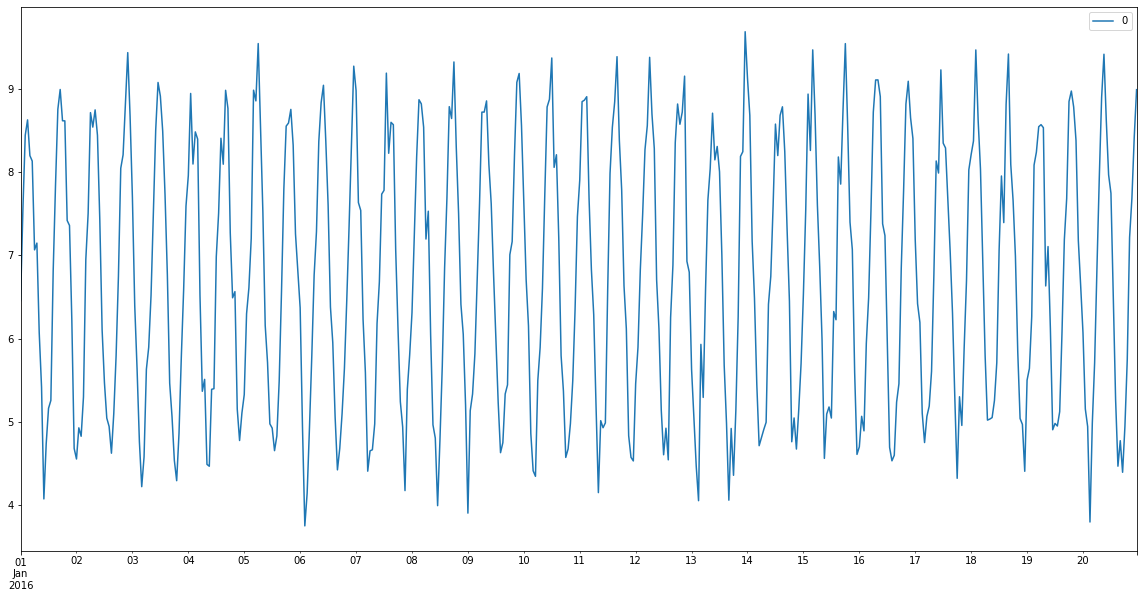

In [4]:
time_series_df.T.plot()

We split the time series dataset in **train and test**

In [5]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:-1]

In [6]:
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], timesteps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], timesteps)

# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features)) 

In [7]:
y_test = ts_Y_test.reshape((ts_Y_test.shape[0], 1))
y_train = ts_Y_train.reshape((ts_Y_train.shape[0], 1))

### UMAL Implementation

The **objective of the UMAL model** is to estimate an heterogeneous predictive density function P(Y|X=x) that will give us a closest estimate to the real posterior or predictive density function without making strong assumptions. The **theory and formulation** behind this concept is explained in detail [here](#https://github.com/beeva/TEC_LAB-bayesian_probabilistic/tree/master/poc_forecasting_uncertainty/techniques/umal)

**Considerations**

* The implementation of UMAL is agnostic of the function used to estimate the predictions. In this case, we will use an [LSTM](#https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/poc_forecasting_uncertainty/techniques/deepquantile_lstm/lstm_dqr_synthdata.ipynb) for this purpose.

* In order to implement an UMAL we need to change the **loss function** and the **input vector** to be able to build a composed vector that could give us as output the prediction and the parameters of each ALD for each prediction

#### Loss function

The UMAL loss function is adapted to **estimate the parameters of ALD contained in tensor parameters (mu, b, tau)**. We will use Maximum Likelihood Estimation to get an estimation of the parameters of the ALD distribution and the Pinball function as the loss.

In [8]:
def independent_ALD_loss(y_true, parameters):
    """
      y_true: [bs, 1]
      parameters: [bs, N_taus, 3]
    """
    mu = parameters[:,:,:1] #[bs, N_taus, 1]
    b = parameters[:,:,1:2] #[bs, N_taus, 1]
    tau = parameters[:,:,-1:] #[bs, N_taus, 1]
    y_1 = y_true[:,tf.newaxis,:1] #[bs, 1, 1]
    y = tf.repeat(y_1,tf.shape(mu)[1],axis=1, name='repeat_-1') #[bs, N_taus, 1]
    
    factor = tf.math.log(tau) + tf.math.log(1-tau) - tf.math.log(b)

    return - tf.reduce_mean(tf.reduce_sum(factor - tf.maximum(tau*(y-mu),(tau-1.)*(y-mu))/b , 
                                         axis=1) - tf.math.log(tf.cast(tf.shape(mu)[1], tf.float32)))

#### UMAL Model

The UMAL model has 2 modes (train, test). These modes are defined by the input variable 'is_train'. It receives as input (dataset)

**Train**: We use MC sampling to **estimate the ALDs parameters of the UMAL the posterior predictive distribution** using N ALDs. The number of ALDs is defined by N_taus.
   
  - 1) **Initialization of ALDs** - We create N taus sampled from an uniform distribution. This distribution represents a non-informative prior since it gives equal values to all taus. We obtain TAU tensor.
  - 2) **Input tensor transformation** - We reshape both tensors (INPUT and TAU) to create a composed tensor as the new input for the model
  - 3) **Estimation of parameters of ALDs** - In training we will fit the parameters of the ALD with two more layers. The loss function is adapted accordingly to minimize the negative log-likelihood function with respect to the weights

**Test**: Obtain of the next point-of-estimation along with the UMAL distribution using the test observations. We receive as input the quantiles or tau list that we are interested in. These quantiles will serve as an approximation for the posterior distribution.

In [9]:
class Implicit_ALD(tf.keras.Model):
    def __init__(self):
        super(Implicit_ALD, self).__init__()
        self.h_1 = tf.keras.layers.LSTM(50, activation='relu', name='LSTM_01')
        self.h_2_mu = tf.keras.layers.Dense(1)
        self.h_2_b = tf.keras.layers.Dense(1, activation = lambda x: tf.keras.activations.elu(x+5.)+1.+1e-5)


    def call(self, inputs, N_taus = 100, is_train = True, tau = [[0.5], [0.9], [0.7]]):
        """
        inputs: [bs, ts, f]
        """
        # 2 EXECUTION MODES - Train and test
        if is_train: # MC sampling to estimate the ALDs parameters of the UMAL posterior predictive distribution
            # Initialization of ALDs - we create as many taus as obs in the batch (bs) 
            tau = tf.random.uniform((tf.shape(inputs)[0], N_taus, 1, 1), minval=1e-2, maxval=1.-1e-2) # [bs, N_taus, 1, 1]
        else:
            tau = tf.repeat(tf.reshape(tau,(1,-1,1,1), name='reshape_0'), repeats=tf.shape(inputs)[0], axis=0, name='repeat_0') # [bs, N_taus, 1, 1]
            N_taus = np.shape(tau)[1]
    
        #---------------- Input tensor transformation
        i_1 = tf.keras.backend.expand_dims(inputs,axis=1) #[bs, 1, ts, fs]

        # RESHAPE INPUT and TAU - Adapt the input to be able to associate each input point with a tau
        i_b = tf.repeat(i_1, N_taus, axis=1, name='repeat_1') #[bs, N_taus, ts, fs]
        tau_b = tf.repeat(tau, inputs.shape[1], axis=2, name='repeat_2') #[bs, N_taus, ts, fs]
    
        # CONCAT INPUT and TAU - Build the final input of the model
        input_tau = tf.keras.layers.concatenate([i_b, tau_b], axis=-1) # [bs, N_taus, ts, fs+1]
        input_tau = tf.reshape(input_tau, [-1, tf.shape(inputs)[1], inputs.shape[-1]+1], name='repeat_3') #[bs * N_taus, ts, fs+1]

        #---------------- Model 
        # MODEL - Apply any deep learning function - we use a LSTM as defined in the constructor 
        hidden_1 = self.h_1(input_tau)
        hidden_2_mu = self.h_2_mu(hidden_1) #[bs, N_taus, 1]
        hidden_2_b = self.h_2_b(hidden_1) #[bs, N_taus, 1]

        output_tau = tf.keras.layers.concatenate([tf.reshape(hidden_2_mu, tf.shape(tau[...,0]), name='reshape_4_mu'), 
                                              tf.reshape(hidden_2_b, tf.shape(tau[...,0]), name='reshape_4_b'), 
                                              tau[...,0]], 
                                             axis=-1)

        return output_tau

**IMPORTANT NOTE**: In this implementation we notice that the definition of the net is implemented in the constructor of a Python class. This is the recommended implementation when we have a network with 2 different modes as described above.
    
Reference: https://keras.io/api/models/model/ 

    If you subclass Model, you can optionally have a training argument (boolean) in call, which you can use to specify a different behavior in training and inference

In [10]:
X_train.shape

(358, 2, 1)

In [11]:
model = Implicit_ALD()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = independent_ALD_loss)
independent_ALD_loss(y_train[:100].astype('float32'), model(X_train[:100])).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([])

We call the function independent_ALD_loss as a double check of tensor types, but it is not required to build the model.

Train on 322 samples, validate on 36 samples
Epoch 1/10000
322/322 [==============================] - 2s 7ms/sample - loss: 434.4324 - val_loss: 433.8298
Epoch 2/10000
322/322 [==============================] - 0s 344us/sample - loss: 429.7348 - val_loss: 429.3880
Epoch 3/10000
322/322 [==============================] - 0s 353us/sample - loss: 424.1439 - val_loss: 423.6121
Epoch 4/10000
322/322 [==============================] - 0s 347us/sample - loss: 416.0676 - val_loss: 407.5926
Epoch 5/10000
322/322 [==============================] - 0s 353us/sample - loss: 398.2119 - val_loss: 380.8952
Epoch 6/10000
322/322 [==============================] - 0s 335us/sample - loss: 355.6743 - val_loss: 289.5652
Epoch 7/10000
322/322 [==============================] - 0s 353us/sample - loss: 283.2049 - val_loss: 274.1565
Epoch 8/10000
322/322 [==============================] - 0s 347us/sample - loss: 271.6032 - val_loss: 265.4111
Epoch 9/10000
322/322 [==============================] - 0s 347us/sam

Epoch 74/10000
322/322 [==============================] - 0s 338us/sample - loss: 138.8885 - val_loss: 154.6122
Epoch 75/10000
322/322 [==============================] - 0s 294us/sample - loss: 134.4887 - val_loss: 155.0524
Epoch 76/10000
322/322 [==============================] - 0s 307us/sample - loss: 135.9264 - val_loss: 153.5305
Epoch 77/10000
322/322 [==============================] - 0s 294us/sample - loss: 135.5220 - val_loss: 159.1633
Epoch 78/10000
322/322 [==============================] - 0s 294us/sample - loss: 144.5699 - val_loss: 155.5284
Epoch 79/10000
322/322 [==============================] - 0s 310us/sample - loss: 135.4719 - val_loss: 156.5383
Epoch 80/10000
322/322 [==============================] - 0s 279us/sample - loss: 133.1302 - val_loss: 156.3823
Epoch 81/10000
322/322 [==============================] - 0s 266us/sample - loss: 136.2259 - val_loss: 159.3815
Epoch 82/10000
322/322 [==============================] - 0s 292us/sample - loss: 132.9913 - val_loss: 1

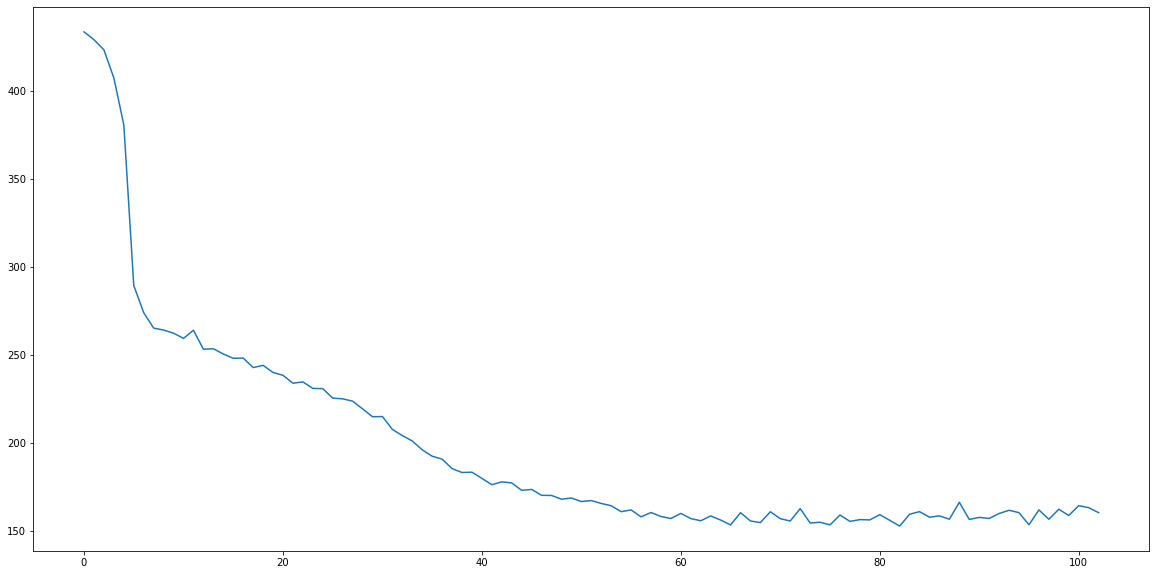

In [12]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.1,verbose=1, epochs=10000, callbacks=[es])

from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])

In [13]:
tau_list = [[0.1],[0.3],[0.5],[0.7],[0.9]] 

We use 5 quantiles [0.1, 0.3, 0.5, 0.7, 0.9] to forecast uncertainty. *As the number of quantiles, the estimated distribution will get closer to the real one*. 

This selection might be done using business knowledge or using a high number of quantiles to discover useful information in scenarios of high uncertainty

In [14]:
pred = model(X_test, is_train=False, tau=tau_list, N_taus=3)

In [15]:
pred_tmp = pred.numpy()

In [22]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, pred):
    plt.figure(figsize=(20,10))
    forecast_h = pred.shape[0]
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window    
    x_range = np.arange(x_length)

    plt.plot(x_range[:train_window], X_train[:, 1,0], '-o', label="train")
    plt.plot(x_range[train_window:], X_test[:,1,0], '-o', label="test")
    plt.errorbar(x_range[train_window:], pred[:,0,0], yerr=pred[:,0,1], label='$q_{0.1}$')
    plt.errorbar(x_range[train_window:], pred[:,1,0], yerr=pred[:,1,1], label='$q_{0.3}$')
    plt.errorbar(x_range[train_window:], pred[:,2,0], yerr=pred[:,2,1], label='$q_{0.5}$')
    plt.errorbar(x_range[train_window:], pred[:,3,0], yerr=pred[:,3,1], label='$q_{0.7}$')
    plt.errorbar(x_range[train_window:], pred[:,4,0], yerr=pred[:,4,1], label='$q_{0.9}$')
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)

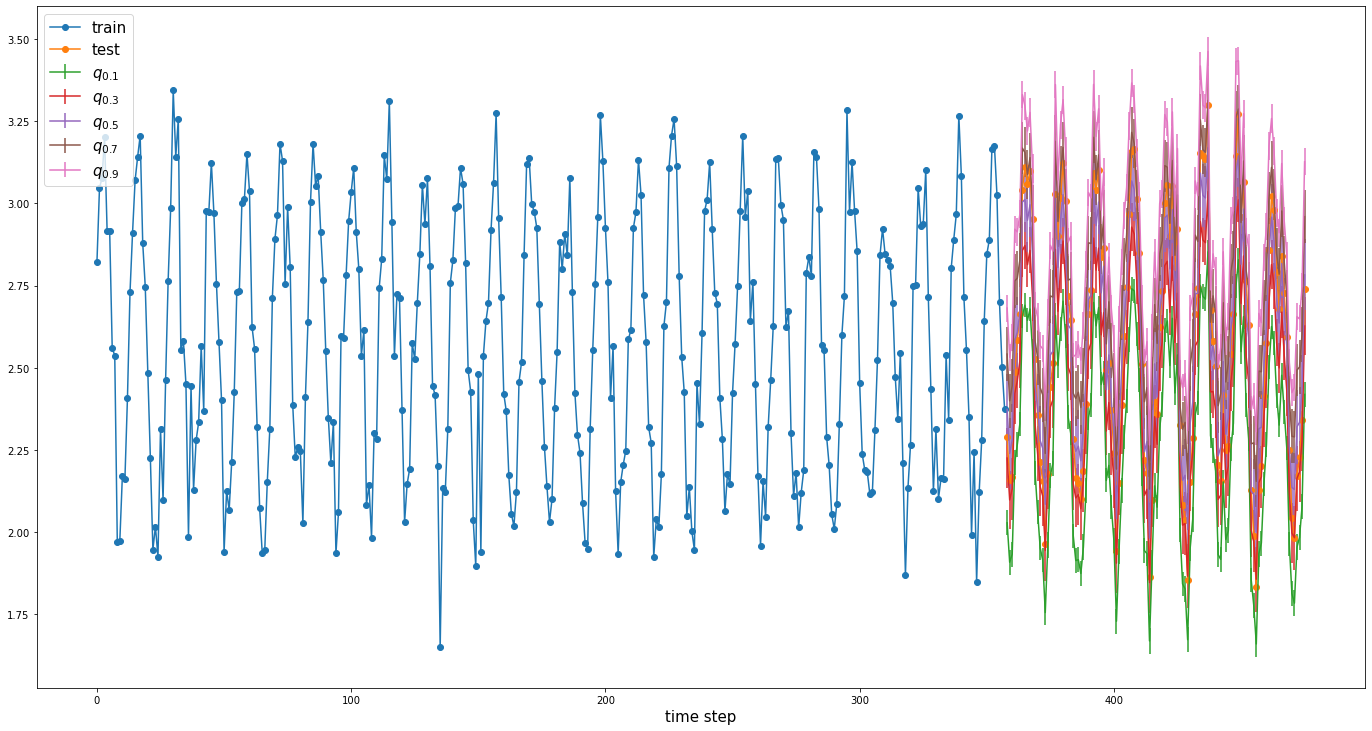

In [23]:
plot_ts_forecast(ts_Y_train, ts_Y_test, pred)

Zoom the test time interval to better visualize the quantile estimation

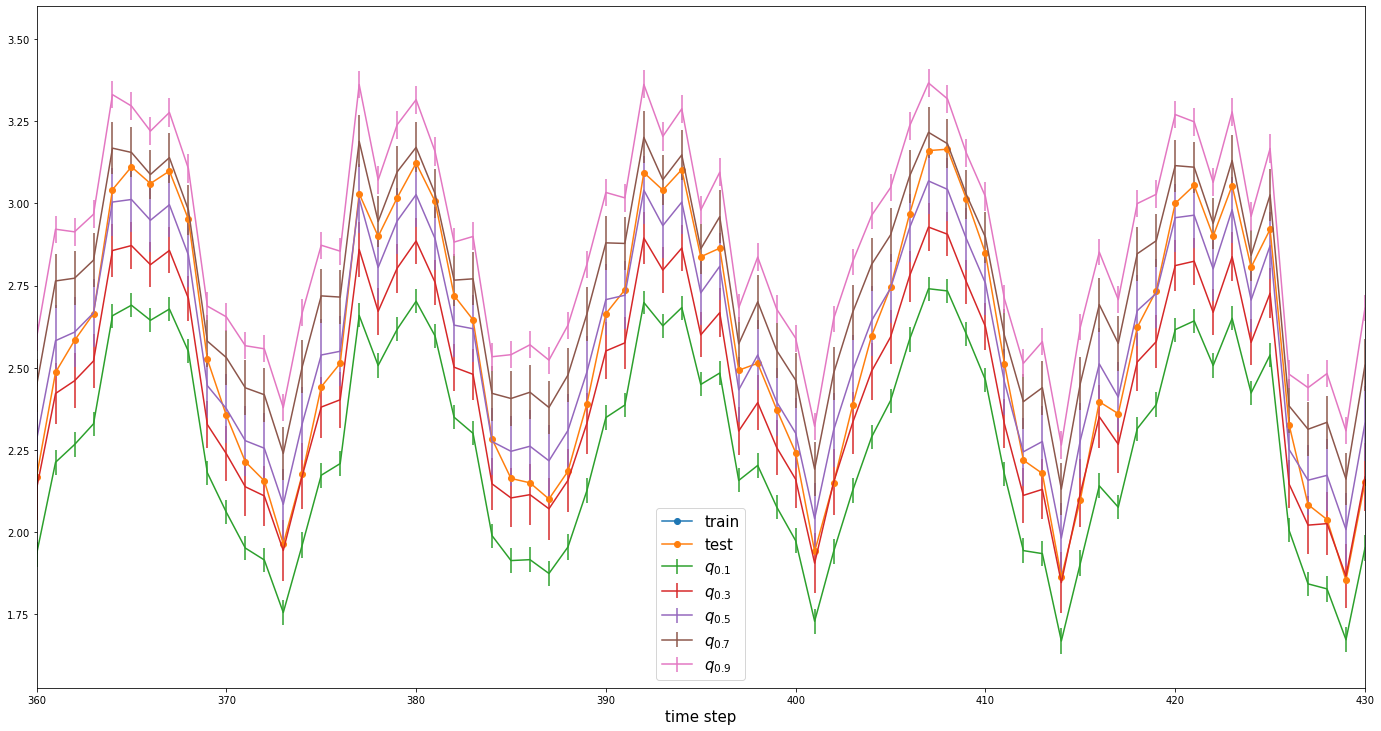

In [24]:
plot_ts_forecast(ts_Y_train, ts_Y_test, pred)
plt.xlim(360,430)
plt.show()

In this plot we can see the prediction intervals and variance associated to each of them. (the variance is represented as a vertical line associated with each prediction interval plotted on different colors)

Here, we can observe that the last and first quantiles have less variance than the ones close to the median. This effect might be caused by the simplicity of the  data: the synthetic dataset has only 1 time series with very little noise.

## Conclusions

* We have shown that UMAL can be used to forecast uncertainty
* This uncertainty is interpreted in terms of prediction intervals. These prediction intervals help us to analyse the predictions for the best and worst case scenarios.

**Main Advantages** 

* (1) UMAL provide a variance estimation for each prediction intervals as opposite of Deep Quantile Regression techniques that **assumes the same variance for all prediction intervals**
* (2) It **solves the crossing quantile problem**


* Both advantages (1),(2) lead us to an improvement of prediction accuracy, particularly useful in scenarios with high uncertainty. 
* We can potentially use the variance estimation of each prediction interval to better select the appropiate forecast horizon